In [1]:
%matplotlib notebook
import tessreduce as tr
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.coordinates import SkyCoord
from astropy import units as u

# HV 6327

In [2]:
ra = 5.079625
dec = -73.8689167

In [13]:
c = SkyCoord(ra=float(ra)*u.degree, dec=float(dec) *u.degree, frame='icrs')
tess = lk.search_tesscut(c,sector=13)
tpf = tess.download(cutout_size=50)
aper_b18 = np.zeros(tpf.shape[1:], dtype=bool)
#aper_b18[44:48, 44:47] = True
res = tr.Quick_reduce(tpf,calibrate=False)#,aper=aper_b18)

made reference
made source mask
calculating background
background subtracted
calculating centroids
images shifted
made light curve


In [14]:
bkg = tr.Make_lc(tpf.astropy_time.mjd,res['bkg'])

<IPython.core.display.Javascript object>


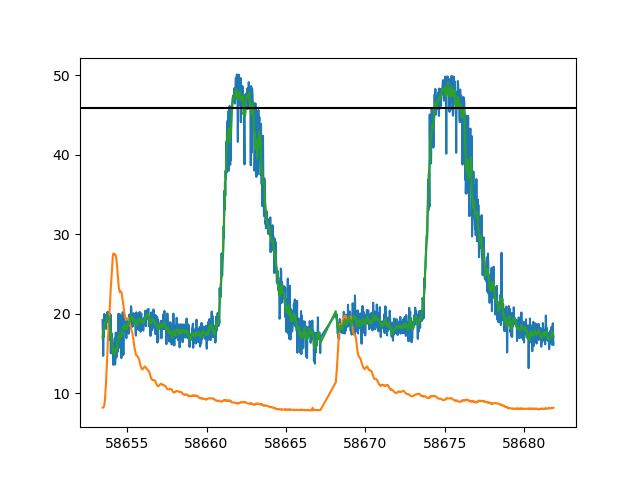

In [15]:
lc = res['lc']
test = tr.Remove_stellar_variability(lc)
l = np.percentile(lc[1],90)
plt.figure()
plt.plot(lc[0],lc[1])
plt.plot(bkg[0],bkg[1]/100)
plt.plot(lc[0],test)
plt.axhline(l,color='k')

In [5]:
isinstance([],list)

True

<IPython.core.display.Javascript object>


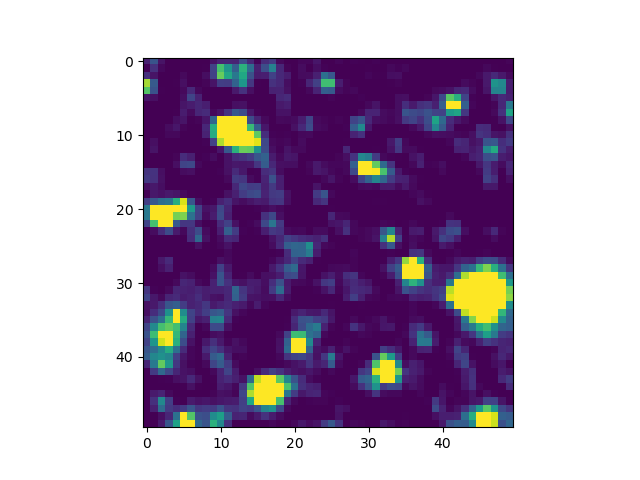

In [17]:
plt.figure()
plt.imshow(res['flux'][100],vmax=100)